# First and Second Derivative of Function

In [1]:
using ITensors
using Plots
using HDF5

Define function of interest

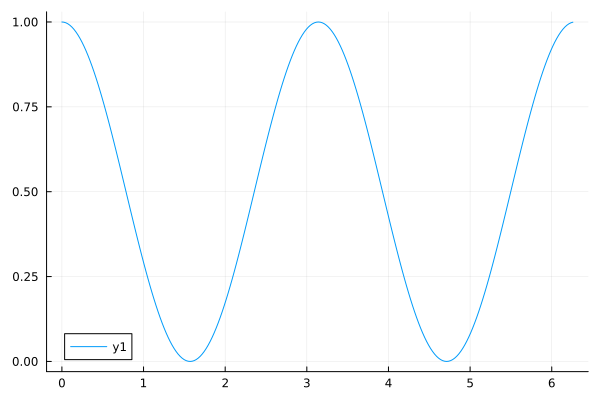

In [2]:
N = 8; # Number of sites
s = siteinds("Qubit", N); # Indices for all sites
xs = range(0, 2pi*(1-(1/2^N)), length=2^N); # Sampling grid points
step_size = 2pi/(2^N);

f(x) = cos(x).^2;
ys = f.(xs);

plot(xs, ys) # Plotting the function

Encode function as MPS

In [3]:
cutoff = 1E-16;
χ = 30;

ψ = MPS(ys, s, cutoff=cutoff, maxdim=χ);

orthogonalize!(ψ,1)

@show linkdims(ψ);

linkdims(ψ) = [2, 3, 3, 3, 3, 2, 1]


Define MPO for first and second derivatives, using central finite difference up to second order

In [4]:
# Left shift:

left_ls = zeros(2, 2, 2) 
middle_ls = zeros(2, 2, 2, 2) 
right_ls = zeros(2, 2, 2) 

left_ls[1, 2, 2] = 1
left_ls[2, 1, 1] = 1
middle_ls[1, 1, 1, 1] = 1
middle_ls[1, 2, 2, 1] = 1
middle_ls[2, 2, 1, 1] = 1
middle_ls[2, 1, 2, 2] = 1
right_ls[1, 1, 1] = 1
right_ls[1, 2, 2] = 1
right_ls[2, 1, 2] = 1
right_ls[2, 2, 1] = 1

H_ls = MPO(N);

α = [Index(2) for i in 1:(N-1)]; # bond indices

for i = 1:N
    if i == 1 # first site
        H_ls[i] = ITensor(left_ls, s[i], s[i]', α[i]);
    elseif i == N # last site
        H_ls[i] = ITensor(right_ls, α[i-1], s[i], s[i]');
    else # middle site
        H_ls[i] = ITensor(middle_ls, α[i-1], s[i], s[i]', α[i]);
    end
end

orthogonalize!(H_ls,1);

# Right shift:

left_rs = zeros(2, 2, 2) 
middle_rs = zeros(2, 2, 2, 2) 
right_rs = zeros(2, 2, 2) 

left_rs[1, 2, 1] = 1
left_rs[2, 1, 2] = 1
middle_rs[1, 1, 1, 1] = 1
middle_rs[1, 2, 2, 1] = 1
middle_rs[2, 1, 2, 1] = 1
middle_rs[2, 2, 1, 2] = 1
right_rs[1, 1, 1] = 1
right_rs[1, 2, 2] = 1
right_rs[2, 1, 2] = 1
right_rs[2, 2, 1] = 1

H_rs = MPO(N);

α = [Index(2) for i in 1:(N-1)]; # bond indices

for i = 1:N
    if i == 1 # first site
        H_rs[i] = ITensor(left_rs, s[i], s[i]', α[i]);
    elseif i == N # last site
        H_rs[i] = ITensor(right_rs, α[i-1], s[i], s[i]');
    else # middle site
        H_rs[i] = ITensor(middle_rs, α[i-1], s[i], s[i]', α[i]);
    end
end

orthogonalize!(H_rs,1);

# Identity:

left_id = zeros(2, 2, 1) 
middle_id = zeros(1, 2, 2, 1) 
right_id = zeros(1, 2, 2) 

left_id[1, 1, 1] = 1
left_id[2, 2, 1] = 1
middle_id[1, 1, 1, 1] = 1
middle_id[1, 2, 2, 1] = 1
right_id[1, 1, 1] = 1
right_id[1, 2, 2] = 1

H_id = MPO(N);

α = [Index(1) for i in 1:(N-1)]; # bond indices

for i = 1:N
    if i == 1 # first site
        H_id[i] = ITensor(left_id, s[i], s[i]', α[i]);
    elseif i == N # last site
        H_id[i] = ITensor(right_id, α[i-1], s[i], s[i]');
    else # middle site
        H_id[i] = ITensor(middle_id, α[i-1], s[i], s[i]', α[i]);
    end
end

orthogonalize!(H_id,1);

# Define derivatives
#H_dudx = 0.5*(H_ls - H_rs)/step_size; # First derivative
#H_d2udx2 = (H_rs + H_ls - 2*H_id)/(step_size^2); # Second derivative


MPO
[1] ((dim=2|id=570|"Qubit,Site,n=1"), (dim=2|id=570|"Qubit,Site,n=1")', (dim=1|id=4))
[2] ((dim=2|id=701|"Qubit,Site,n=2"), (dim=2|id=701|"Qubit,Site,n=2")', (dim=1|id=389), (dim=1|id=4))
[3] ((dim=2|id=460|"Qubit,Site,n=3"), (dim=2|id=460|"Qubit,Site,n=3")', (dim=1|id=269), (dim=1|id=389))
[4] ((dim=2|id=779|"Qubit,Site,n=4"), (dim=2|id=779|"Qubit,Site,n=4")', (dim=1|id=472), (dim=1|id=269))
[5] ((dim=2|id=903|"Qubit,Site,n=5"), (dim=2|id=903|"Qubit,Site,n=5")', (dim=1|id=976), (dim=1|id=472))
[6] ((dim=2|id=480|"Qubit,Site,n=6"), (dim=2|id=480|"Qubit,Site,n=6")', (dim=1|id=233), (dim=1|id=976))
[7] ((dim=2|id=644|"Qubit,Site,n=7"), (dim=2|id=644|"Qubit,Site,n=7")', (dim=1|id=574), (dim=1|id=233))
[8] ((dim=2|id=547|"Qubit,Site,n=8"), (dim=2|id=547|"Qubit,Site,n=8")', (dim=1|id=574))


In [5]:
rs=MPS(N);
ls=MPS(N);
rs1=MPS(N);
ls1=MPS(N);
rs2=MPS(N);
ls2=MPS(N);
rs3=MPS(N);
ls3=MPS(N);
rs4=MPS(N);
ls4=MPS(N);
ψ2 = deepcopy(ψ);
for i= 1:4
    rs = apply(H_rs,ψ);
    ψ=rs
    #ls = apply(H_ls,ψ2);
    #ψ2=ls
    #@show ls
    if (i == 1) 
        rs1=deepcopy(rs);
     #   ls1=deepcopy(ls);
        #@show ls1
    elseif(i == 2) 
        rs2=deepcopy(rs);
      #  ls2=deepcopy(ls);
       # @show ls2
    elseif(i == 3) 
        rs3=deepcopy(rs);
        #ls3=deepcopy(ls);
        #@show ls3
    elseif(i==4)
        rs4=deepcopy(rs);
        #ls4=deepcopy(ls);
        #@show ls4
    end

end   
for i= 1:4
    #rs = apply(H_rs,ψ);
    #ψ=rs
    ls = apply(H_ls,ψ2);
    ψ2=ls
    #@show ls
    if (i == 1) 
     #   rs1=deepcopy(rs);
        ls1=deepcopy(ls);
        #@show ls1
    elseif(i == 2) 
      #  rs2=deepcopy(rs);
        ls2=deepcopy(ls);
       # @show ls2
    elseif(i == 3) 
        #rs3=deepcopy(rs);
        ls3=deepcopy(ls);
        #@show ls3
    elseif(i==4)
        #rs4=deepcopy(rs);
        ls4=deepcopy(ls);
        @show ls4
    end

end   


##r_d= (1/280*ls4-4/105*ls3+1/5*ls2-4/5*ls1+4/5*rs1-1/5*rs2+4/105*rs3-1/280*rs4)/step_size;


ls4 = MPS
[1] ((dim=2|id=589|"Link,n=1"), (dim=2|id=570|"Qubit,Site,n=1"))
[2] ((dim=2|id=701|"Qubit,Site,n=2"), (dim=3|id=458|"Link,n=2"), (dim=2|id=589|"Link,n=1"))
[3] ((dim=2|id=460|"Qubit,Site,n=3"), (dim=3|id=604|"Link,n=3"), (dim=3|id=458|"Link,n=2"))
[4] ((dim=2|id=779|"Qubit,Site,n=4"), (dim=3|id=272|"Link,n=4"), (dim=3|id=604|"Link,n=3"))
[5] ((dim=2|id=903|"Qubit,Site,n=5"), (dim=3|id=665|"Link,n=5"), (dim=3|id=272|"Link,n=4"))
[6] ((dim=2|id=480|"Qubit,Site,n=6"), (dim=2|id=269|"Link,n=6"), (dim=3|id=665|"Link,n=5"))
[7] ((dim=2|id=644|"Qubit,Site,n=7"), (dim=1|id=290|"Link,n=7"), (dim=2|id=269|"Link,n=6"))
[8] ((dim=2|id=547|"Qubit,Site,n=8"), (dim=1|id=290|"Link,n=7"))



In [6]:
@show rs4

rs4 = MPS
[1] ((dim=2|id=138|"Link,n=1"), (dim=2|id=570|"Qubit,Site,n=1"))
[2] ((dim=2|id=701|"Qubit,Site,n=2"), (dim=3|id=488|"Link,n=2"), (dim=2|id=138|"Link,n=1"))
[3] ((dim=2|id=460|"Qubit,Site,n=3"), (dim=3|id=915|"Link,n=3"), (dim=3|id=488|"Link,n=2"))
[4] ((dim=2|id=779|"Qubit,Site,n=4"), (dim=3|id=122|"Link,n=4"), (dim=3|id=915|"Link,n=3"))
[5] ((dim=2|id=903|"Qubit,Site,n=5"), (dim=3|id=935|"Link,n=5"), (dim=3|id=122|"Link,n=4"))
[6] ((dim=2|id=480|"Qubit,Site,n=6"), (dim=2|id=443|"Link,n=6"), (dim=3|id=935|"Link,n=5"))
[7] ((dim=2|id=644|"Qubit,Site,n=7"), (dim=1|id=730|"Link,n=7"), (dim=2|id=443|"Link,n=6"))
[8] ((dim=2|id=547|"Qubit,Site,n=8"), (dim=1|id=730|"Link,n=7"))



MPS
[1] ((dim=2|id=138|"Link,n=1"), (dim=2|id=570|"Qubit,Site,n=1"))
[2] ((dim=2|id=701|"Qubit,Site,n=2"), (dim=3|id=488|"Link,n=2"), (dim=2|id=138|"Link,n=1"))
[3] ((dim=2|id=460|"Qubit,Site,n=3"), (dim=3|id=915|"Link,n=3"), (dim=3|id=488|"Link,n=2"))
[4] ((dim=2|id=779|"Qubit,Site,n=4"), (dim=3|id=122|"Link,n=4"), (dim=3|id=915|"Link,n=3"))
[5] ((dim=2|id=903|"Qubit,Site,n=5"), (dim=3|id=935|"Link,n=5"), (dim=3|id=122|"Link,n=4"))
[6] ((dim=2|id=480|"Qubit,Site,n=6"), (dim=2|id=443|"Link,n=6"), (dim=3|id=935|"Link,n=5"))
[7] ((dim=2|id=644|"Qubit,Site,n=7"), (dim=1|id=730|"Link,n=7"), (dim=2|id=443|"Link,n=6"))
[8] ((dim=2|id=547|"Qubit,Site,n=8"), (dim=1|id=730|"Link,n=7"))


In [11]:
r_d= -(1/280*ls4-4/105*ls3+1/5*ls2-4/5*ls1+4/5*rs1-1/5*rs2+4/105*rs3-1/280*rs4)/step_size;

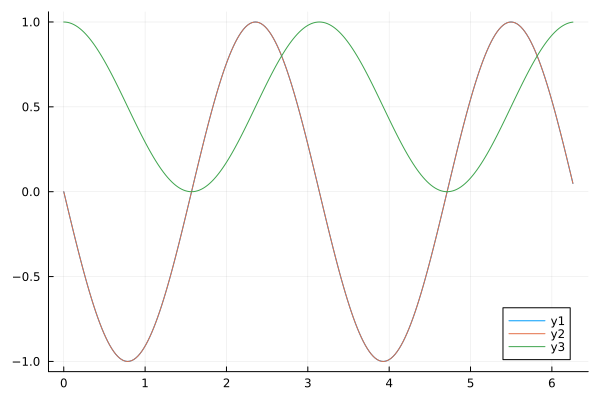

In [12]:

Big_4 = contract(r_d);
J_4 = Array(Big_4, s) 
ys_4 = reshape(J_4,2^N,1) 
f(x) = -sin(2*x);
yd = f.(xs);
plot(xs, yd) 
plot!(xs, ys_4) 
plot!(xs, ys) 

Apply derivatives to MPS encoding function

In [29]:
Deriv1 = apply(H_dudx,ψ);
Deriv2 = apply(H_d2udx2,ψ);

@show linkdims(Deriv1);
@show linkdims(Deriv2);

linkdims(Deriv1) = [2, 2, 2, 2, 2, 1, 1]
linkdims(Deriv2) = [3, 2, 2, 2, 2, 1, 1]


Contract the resulting MPS and plot the results

In [9]:
# Recovering the original big tensors
Big_ψ1 = contract(Deriv1); 
Big_ψ2 = contract(Deriv2); 

# Changing the format from ITensor to Julia array for plotting
J_recon1 = Array(Big_ψ1, s) 
J_recon2 = Array(Big_ψ2, s) 

# Reshaping from N-dimentional tensor to regular array
ys_recon1 = reshape(J_recon1,2^N,1) 
ys_recon2 = reshape(J_recon2,2^N,1) 

# Plotting the reconstructed derivatives of the function
plot(xs, ys_recon1) 
plot!(xs, ys_recon2) 

UndefVarError: UndefVarError: `Deriv1` not defined

Exercise finished!!!

In [18]:
using ITensors
using LinearAlgebra

N = 8

# Define the spatial domain
x = LinRange(0, 2π, N+1)[1:end-1]
Δx = x[2] - x[1]

# Function f(x) = cos^2(x)
f = cos.(x).^2

# Analytical first derivative
df_analytical = -2 * cos.(x) .* sin.(x)

# Analytical second derivative
d2f_analytical = -2 * cos.(2x)

# Define the eight-order central finite difference coefficients
coeffs = [1/280, -4/105, 1/5, -4/5, 0, 4/5, -1/5, 4/105, -1/280]

# Pad the function values for periodic boundary conditions
f_padded = vcat(f[end-3:end], f, f[1:4])

# Compute the first derivative
df_numerical = zeros(N)
for i in 1:N
    df_numerical[i] = sum(coeffs .* f_padded[i:i+8]) / Δx
end

# Compute the second derivative
# Second derivative coefficients (second derivative of finite difference)
coeffs2 = [-1/560, 8/315, -1/5, 8/5, -205/72, 8/5, -1/5, 8/315, -1/560]

d2f_numerical = zeros(N)
for i in 1:N
    d2f_numerical[i] = sum(coeffs2 .* f_padded[i:i+8]) / Δx^2
end

# Encode the numerical and analytical results as MPS
sites = siteinds("Qubit", N)
f_mps = MPS(sites)
df_num_mps = MPS(sites)
d2f_num_mps = MPS(sites)
df_an_mps = MPS(sites)
d2f_an_mps = MPS(sites)


ErrorException: invalid redefinition of constant Main.f